In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [2]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [144]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,2)
for lag in lags:
    period = (2000-lag,2004-lag) if not interpolate else (1999-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Cumulative GDP growth
d_gdp_ppp_cum = d_gdp_ppp_lag.sum(axis=1)

# Variances (rolling window, exponential decay)
def calculate_exponentially_weighted_variance(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_index_historical = compute_index_excess_returns(ds, fed, major)
    variances = pd.DataFrame(index=major, columns=panel_dates)
    for i in range(48):
        returns = returns_index_historical.iloc[:,i:i+60]
        means = returns.mean(axis=1)
        returns_demeaned = returns.sub(means, axis=0)
        var_contributions = returns_demeaned**2
        factors = generate_exponential_decay(ratio=ratio)
        variances_temp = var_contributions.mul(factors).sum(axis=1) / sum(factors)
        variances.iloc[:,i] = variances_temp
    variances = variances.stack().rename("variances").astype(float)
    return variances
variances = calculate_exponentially_weighted_variance((1996,2004), panel_dates, 0.9)

def calculate_exponentially_weighted_return(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_world_historical = compute_index_excess_returns(ds, fed, ["WR"])
    expected_world_return = pd.DataFrame(index=["WR"], columns=panel_dates)
    for i in range(48):
        returns = returns_world_historical.iloc[:,i:i+120]
        factors = generate_exponential_decay(ratio=ratio, length=120)
        return_temp = returns.mul(factors).sum(axis=1) / sum(factors)
        expected_world_return.iloc[:,i] = return_temp
    return expected_world_return

In [145]:
from scipy.optimize import minimize_scalar

period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
returns_index_demeaned = returns_index - returns_index.groupby("Country").mean()
returns_index_demeaned_squared = (returns_index_demeaned ** 2)

def compute_r2(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    # model = sm.OLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
    # model = PanelOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa), entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    model = PooledOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    return -model.rsquared


def compute_ss(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    errors = variances_kappa - returns_index_demeaned_squared
    ss = (errors ** 2).to_numpy().sum()
    return ss

kappa_ss = minimize_scalar(compute_ss, bounds=(0,1), method="bounded")
kappa_r2 = minimize_scalar(compute_r2, bounds=(0,1), method="bounded")
print(kappa_r2.x, kappa_ss.x)
print(kappa_r2.fun, kappa_ss.fun)

0.9058656466188171 0.8914021213249128
-0.16591934722811563 0.2678562235517841


In [146]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = PooledOLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

Dep. Variable:,returns,R-squared:,0.3081
Estimator:,PooledOLS,R-squared (Between):,0.9738
No. Observations:,1824,R-squared (Within):,0.0057
Date:,"Sun, May 04 2025",R-squared (Overall):,0.3081
Time:,00:43:38,Log-likelihood,5488.3
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,811.70
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(1,1823)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,122.74


In [147]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = sm.OLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
fe_model = PanelOLS(returns_index_demeaned_squared, variances_kappa, entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

from linearmodels.panel import compare

# Estimate both models
re_model = RandomEffects(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)

# Hausman test

comparison = hausman(fe_model, re_model)
print(comparison)

(np.float64(5.906802770555258), 1, np.float64(0.015082521769819666))


In [148]:
# Collect dependent and independent variables
scale = True
y = returns_index
X = pd.concat([
    variances,
    # gdp_cap_ppp / (1e5),
    d_gdp_ppp_cum,
    returns_world_dummies,
], axis=1)
X = sm.add_constant(X)

In [149]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

Dep. Variable:,returns,R-squared:,0.4443
Estimator:,PanelOLS,R-squared (Between):,-0.2583
No. Observations:,1824,R-squared (Within):,0.4443
Date:,"Sun, May 04 2025",R-squared (Overall):,0.4343
Time:,00:43:39,Log-likelihood,2619.1
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,34.897
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(40,1746)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,2.876e+05


In [143]:
print(pd.DataFrame([model_panel.params, model_panel.std_errors]).T)

           parameter  std_error
const       0.014455   0.009114
variances   0.349985   0.804157
0          -0.074942   0.045799
WRxAR       0.831330   0.252393
WRxAT       0.454124   0.112239
WRxBE       0.853774   0.163396
WRxBR       1.864828   0.276121
WRxCA       0.937141   0.084429
WRxCH       0.831804   0.067497
WRxCL       0.980930   0.113425
WRxCO       0.690317   0.122702
WRxCZ       0.794319   0.209519
WRxDE       1.413694   0.118555
WRxDK       0.963403   0.084277
WRxES       1.074475   0.076870
WRxFI       1.623763   0.254566
WRxFR       1.264467   0.071615
WRxGB       0.901551   0.050419
WRxGR       1.070042   0.169708
WRxHK       1.042098   0.104798
WRxHU       0.949755   0.158004
WRxID       0.790403   0.295266
WRxIL       0.899067   0.199766
WRxIT       1.104240   0.074786
WRxJP       0.672599   0.109541
WRxKR       1.534181   0.169251
WRxMX       0.908608   0.111058
WRxMY       0.484318   0.128840
WRxNL       1.158372   0.119475
WRxNO       1.073892   0.087292
WRxPH   

In [24]:
# Expected world return
period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+60]
    log_returns = np.log(1+returns) # New
    mean_log = log_returns.mean(axis=1).iloc[0] # New
    mean = returns.mean(axis=1).iloc[0]
    returns_world_expectation[i] = mean

In [25]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = np.exp(fitted_returns.sum(axis=1).unstack())-1
temp = ((fitted_returns < 0).T)
def interpolate_negatives(row):
    # Mask negative values with NaN
    row = row.where(row >= 0, np.nan)
    # Interpolate within the row (axis=0 for row-wise here since row is a Series)
    return row.interpolate(method='linear', limit_direction='both')
# Apply row-wise
fitted_returns = fitted_returns.apply(interpolate_negatives, axis=1)

In [26]:
# Covariances
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)

In [27]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [28]:
# eta * f
eta_f = fitted_returns / cov_risks_diag

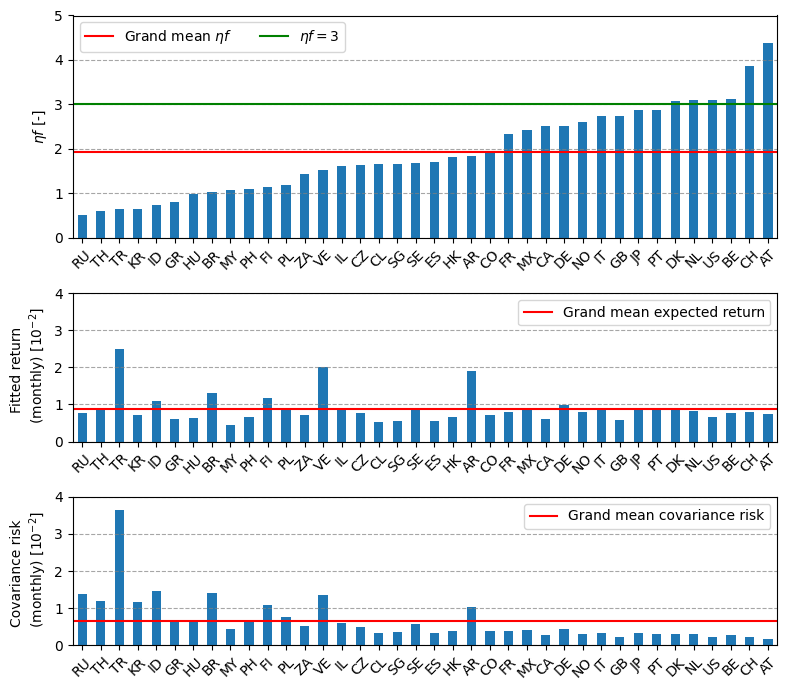

In [29]:
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(3, 1, figsize=(8,7), gridspec_kw={'height_ratios': [3, 2, 2]})

eta_f_mean = eta_f.mean(axis=1).sort_values()
eta_f_mean.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(eta_f_mean.mean(), color="red")
axs[0].axhline(3, color="green")
axs[0].legend(labels=[r"Grand mean $\eta f$", r"$\eta f = 3$"], ncol=2)
axs[0].set_ylabel(r"$\eta f$ [-]") 
axs[0].set_ylim([0,5])

fitted_returns_mean = 100*fitted_returns.mean(axis=1).reindex(eta_f_mean.index)
fitted_returns_mean.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(fitted_returns_mean.mean(), color="red")
axs[1].legend(labels=["Grand mean expected return"], ncol=2)
axs[1].set_ylabel("Fitted return \n (monthly) [$10^{-2}$]") 
axs[1].set_ylim([0,4])

cov_risks_mean = 100*cov_risks_diag.mean(axis=1).reindex(eta_f_mean.index)
cov_risks_mean.plot(kind="bar", ax=axs[2])
axs[2].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[2].get_xticklabels():
    label.set_ha('center')
axs[2].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[2].axhline(cov_risks_mean.mean(), color="red")
axs[2].legend(labels=["Grand mean covariance risk"], ncol=2)
axs[2].set_ylabel("Covariance risk \n (monthly) [$10^{-2}$]") 
axs[2].set_ylim([0,4])

fig.tight_layout()
fig.savefig(dir+"/eta_f.svg")
plt.show()

In [112]:
# Fastest way
costs = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
costs_old = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
cost_diffs = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs[(month, country_i)] = fitted_returns[month] - eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
        costs_old[(month, country_i)] = fitted_returns[month] - 3.0 * covs[month] @ weights[country_i] 
        cost_diffs[(month, country_i)] = costs_old[(month, country_i)] - costs[(month, country_i)]
    print(country_i, end=" ")
print("\n")

AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



In [81]:
cost_gap_diffs = pd.DataFrame(0.0, index=costs.index, columns=costs.columns)
for country_i in major: 
    for country_j in major:
        if country_j < country_i:
            continue            
        for month in stds.columns:
            weights_i = weights[country_i]
            weights_j = weights[country_j]
            cov_i = covs[month].loc[country_i]
            cov_j = covs[month].loc[country_j]
            eta_f_i = eta_f.loc[country_i, month]
            eta_f_j = eta_f.loc[country_j, month]
            weights_diff = (3*(weights_i-weights_j) - (eta_f_i*weights_i - eta_f_j*weights_j))
            cost_gap_diffs.loc[country_i, (month, country_j)] =  cov_i @ weights_diff
            cost_gap_diffs.loc[country_j, (month, country_i)] =  cov_j @ -weights_diff
    print(country_i, end=" ")
print("\n")

AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



In [78]:
# data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
# data_inward = costs.loc["US"].unstack()
# color = plt.get_cmap("turbo", 38)
# ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
# ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
# # plt.show()

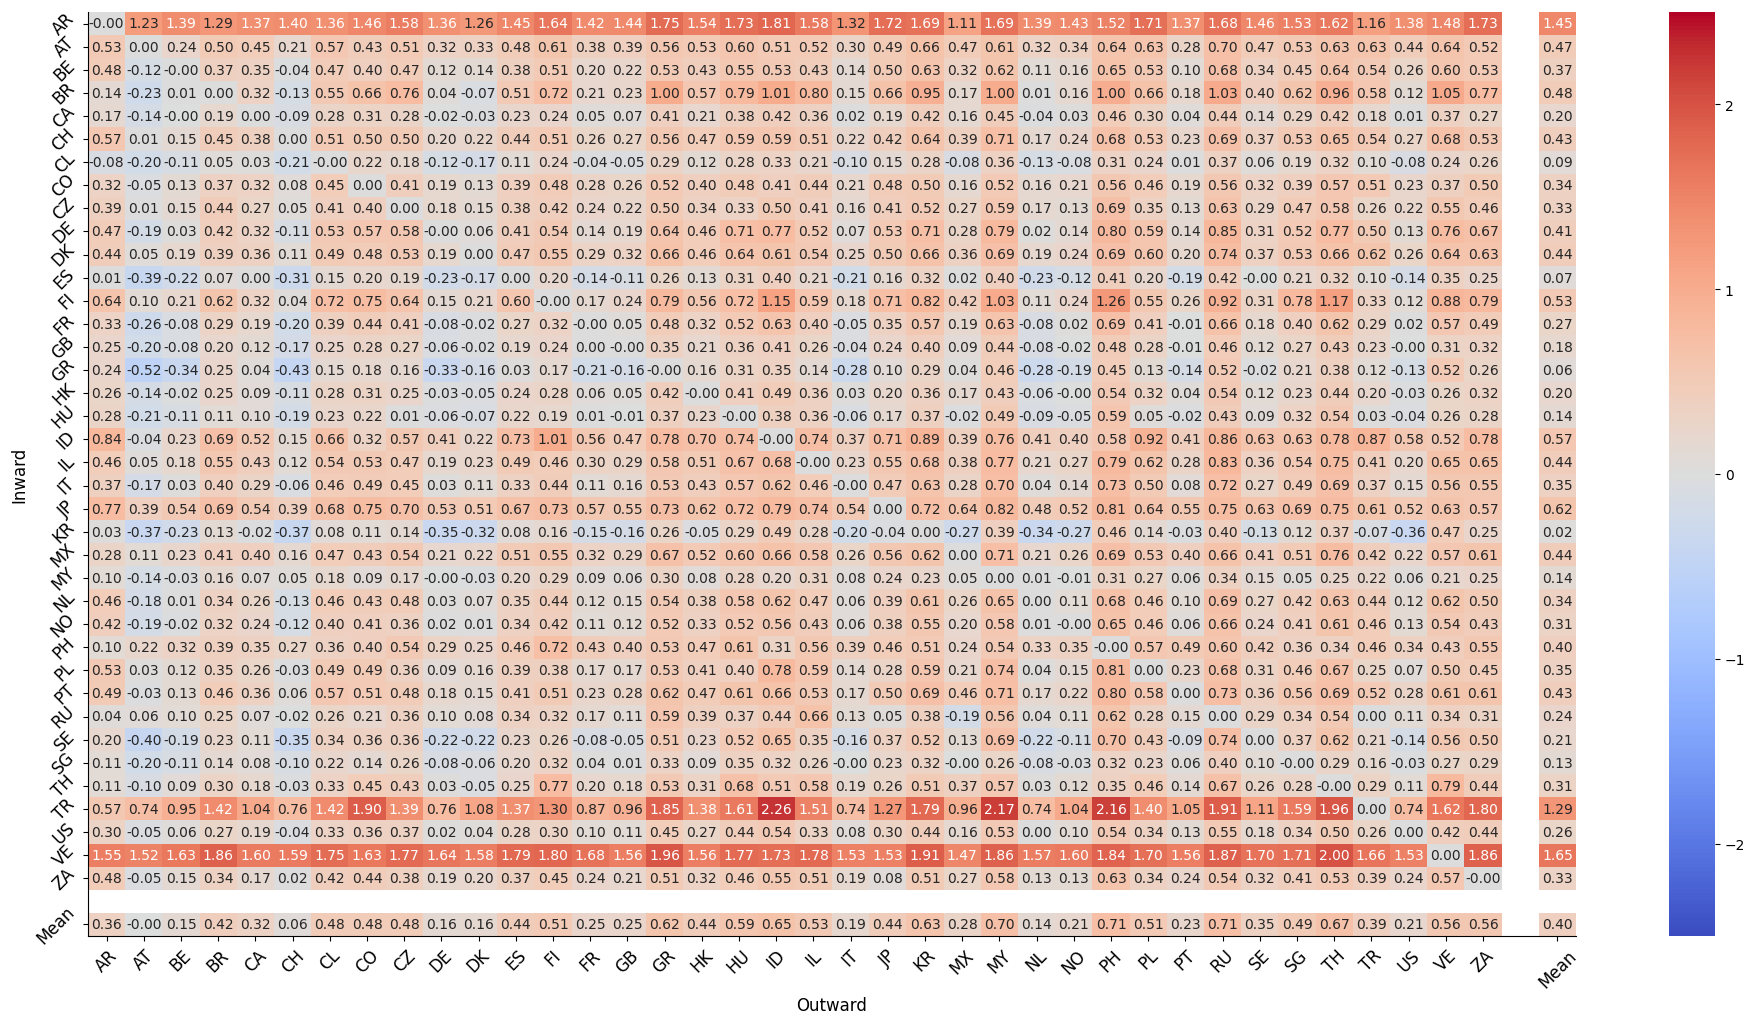

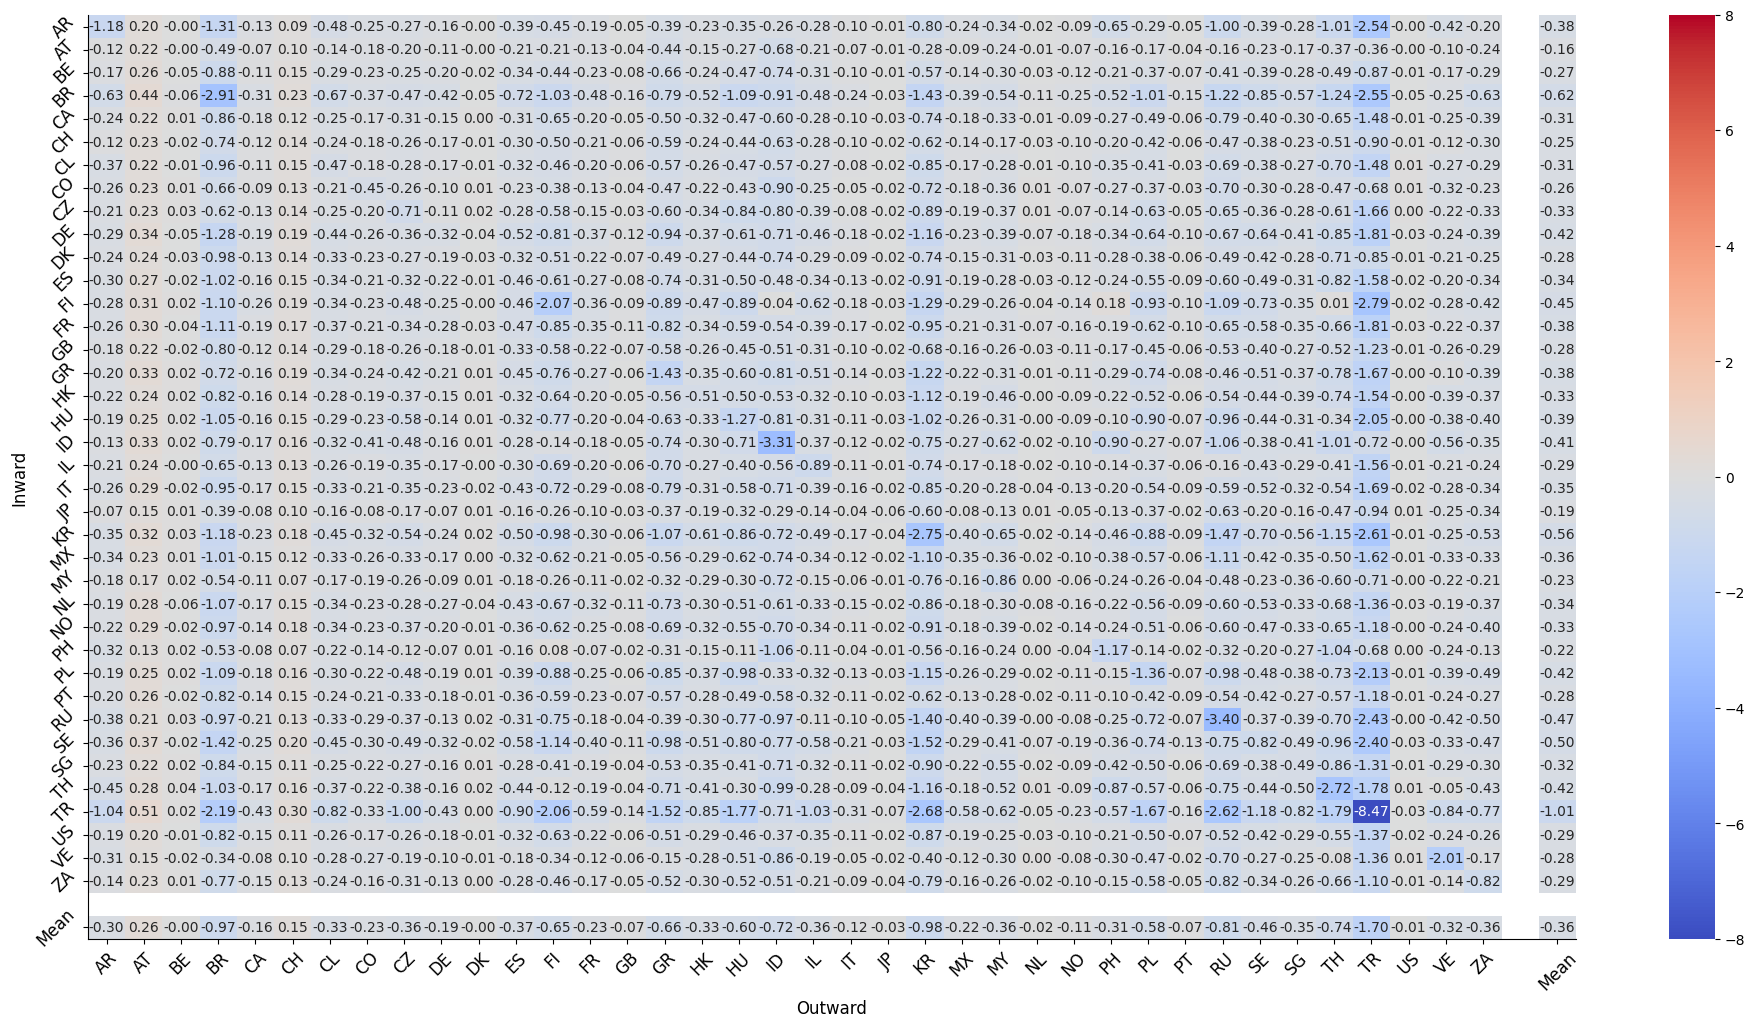

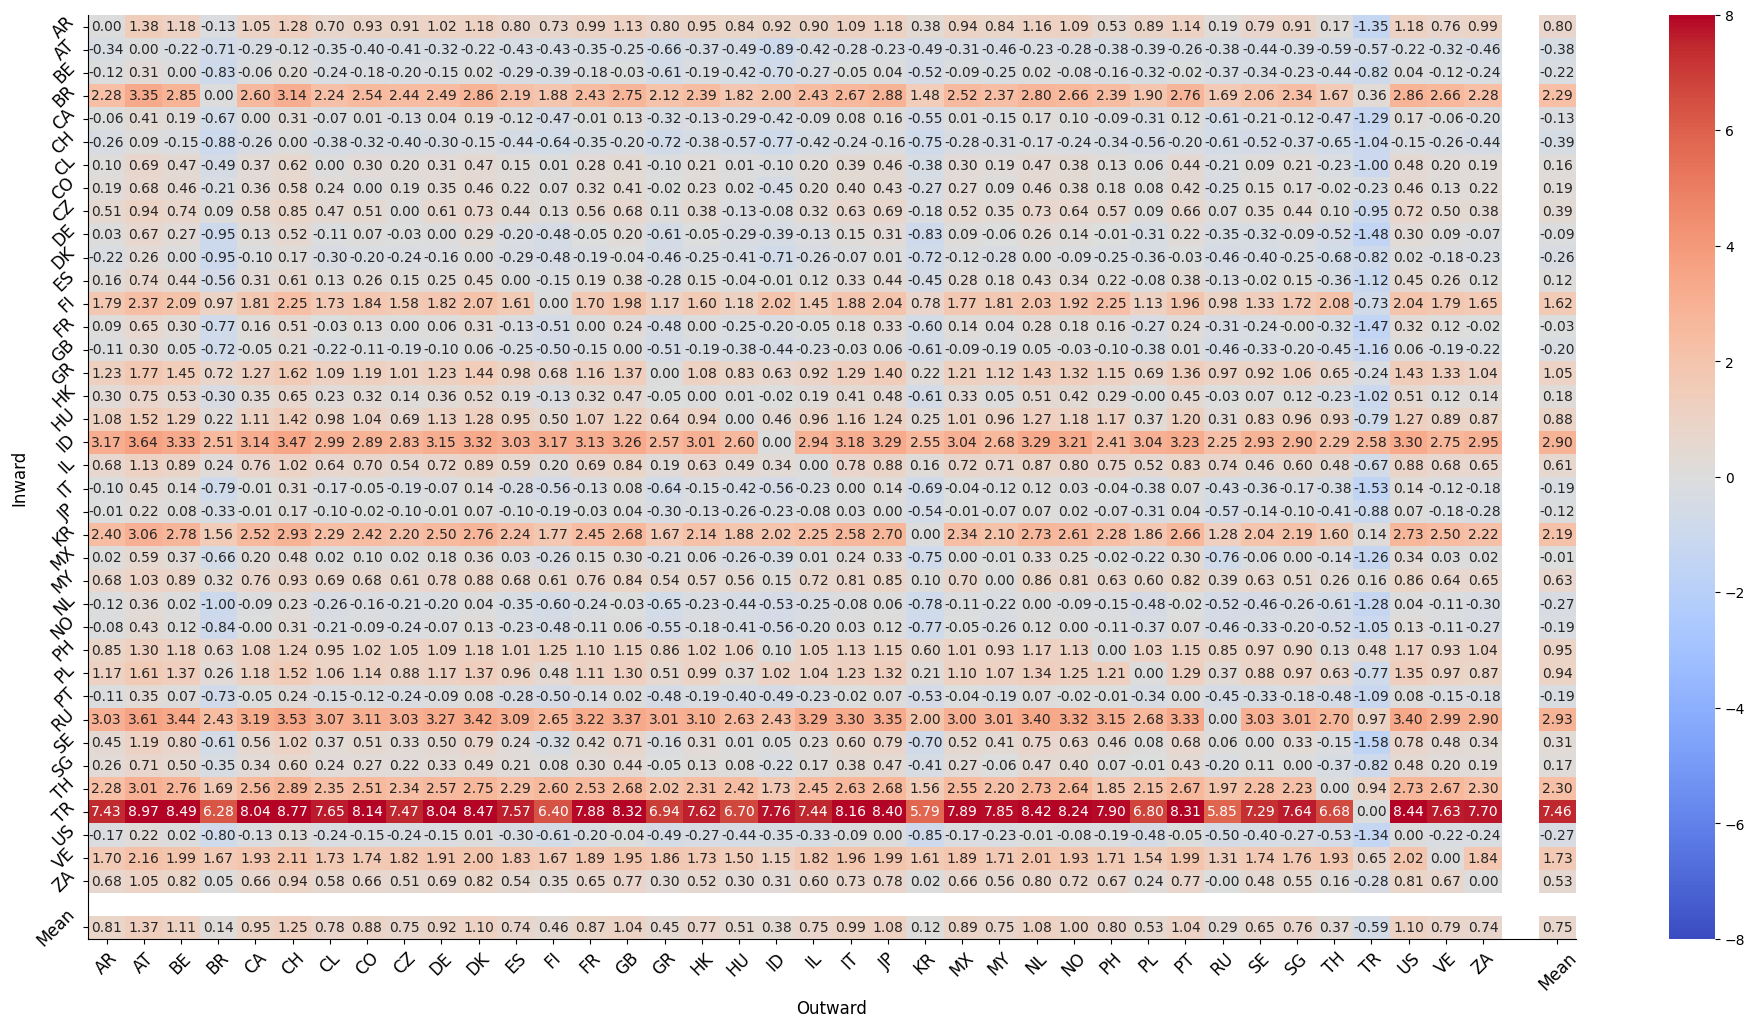

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
def plot_heatmap(data, save_dir, v):
    data = data.copy()
    data[" "] = np.nan
    data["Mean"] = data.mean(axis=1)
    data.loc[" "] = np.nan
    data.loc["Mean"] = data.mean(axis=0)

    fig, ax = plt.subplots(figsize=(24, 12))
    sns.heatmap(data, ax=ax, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmin=-v, vmax=v)
    ax.set_xlabel("Outward")
    ax.set_ylabel("Inward")
    ax.tick_params(axis='both', labelrotation=45, labelsize=12)
    ax.set_xticks([i for i in ax.get_xticks() if i != 38.5])
    ax.set_yticks([i for i in ax.get_xticks() if i != 38.5])
    colorbar = ax.collections[0].colorbar
    sns.despine(fig=fig, ax=ax)
    # Remove the spines from the colorbar
    for spine in colorbar.ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel("Outward", fontsize=ax.get_xticklabels()[0].get_fontsize())
    ax.set_ylabel("Inward", fontsize=ax.get_xticklabels()[0].get_fontsize())
    fig.savefig(save_dir, bbox_inches='tight')
    plt.show()

mean_costs = costs.T.groupby(level=1).mean().astype(float).T * 100
plot_heatmap(
    data=mean_costs, 
    save_dir=dir+"/costs.svg",
    v=2.5,
    )

mean_cost_diffs = cost_diffs.T.groupby(level=1).mean().astype(float).T * 100
plot_heatmap(
    data=mean_cost_diffs,
    save_dir=dir+"/cost_diffs.svg",
    v=8
    )

mean_cost_gap_diffs = cost_gap_diffs.T.groupby(level=1).mean().astype(float).T * 100
plot_heatmap(
    data=mean_cost_gap_diffs,
    save_dir=dir+"/cost_gap_diffs.svg",
    v=8
    )


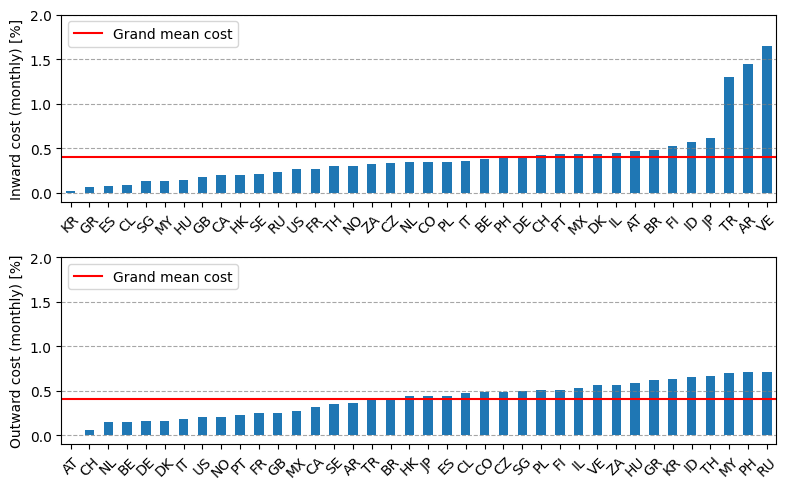

In [19]:
mean_inward_cost = mean_costs.mean(axis=1).sort_values()
mean_outward_cost = mean_costs.mean(axis=0).sort_values()
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [1,1]})

mean_inward_cost.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(mean_inward_cost.mean(), color="red")
axs[0].legend(labels=["Grand mean cost"], loc=2)
axs[0].set_ylabel("Inward cost (monthly) [%]") 
axs[0].set_ylim([-0.1,2])

mean_outward_cost.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(mean_outward_cost.mean(), color="red")
axs[1].legend(labels=["Grand mean cost"], loc=2)
axs[1].set_ylabel("Outward cost (monthly) [%]") 
axs[1].set_ylim([-0.1,2])

fig.tight_layout()
fig.savefig(dir+"/mean_costs.svg")
plt.show()

In [20]:
print("average over means: ", (mean_costs<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.11911357340720222
average over all obs.:  0.18571098799630656


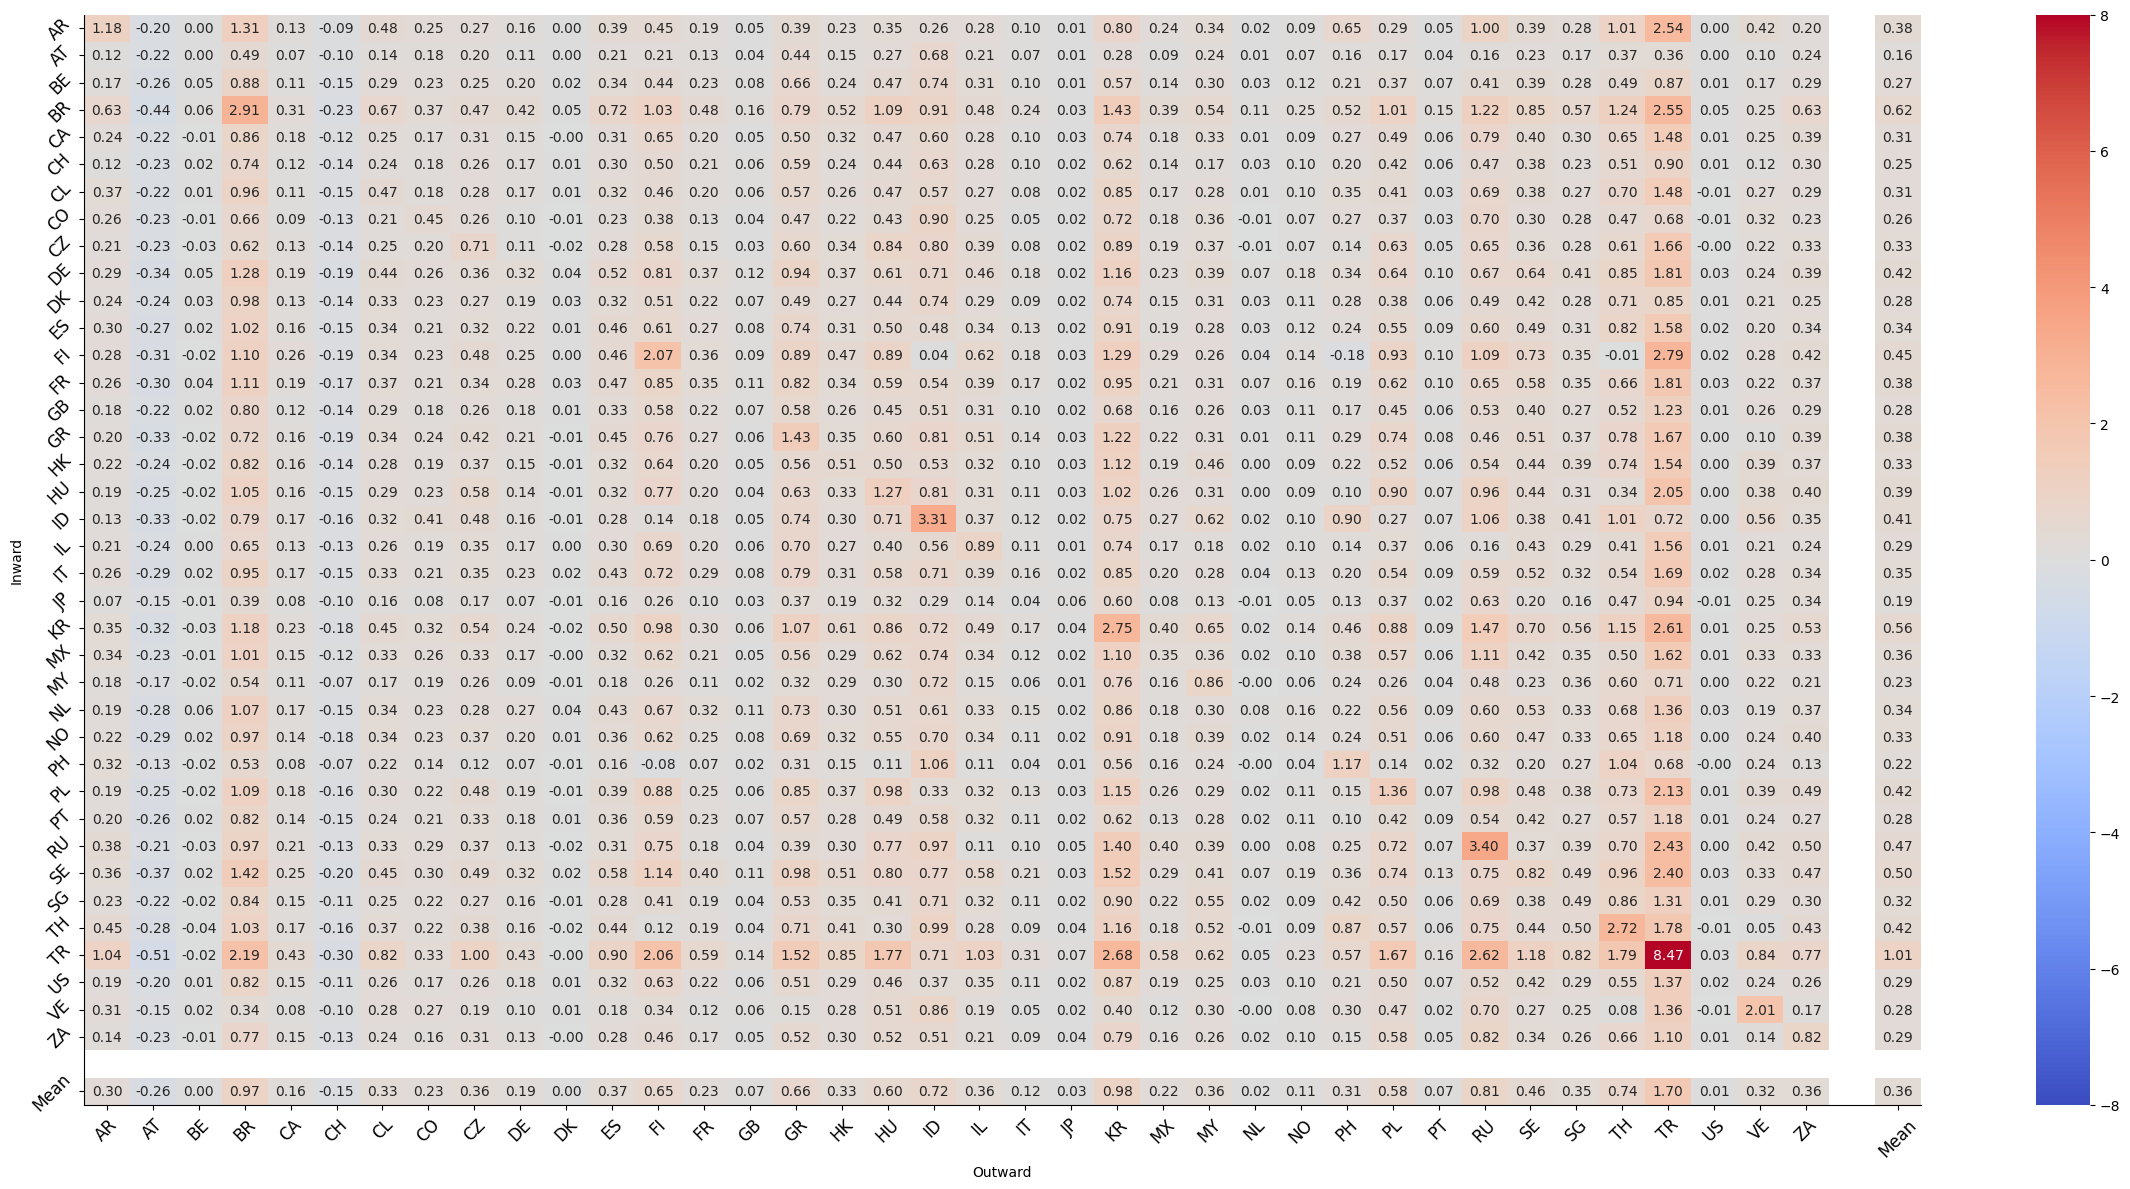

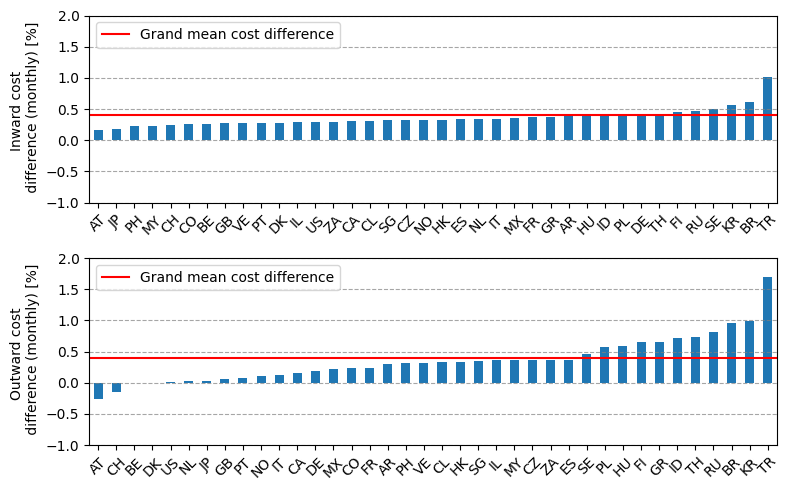

In [63]:
mean_cost_diffs = -cost_diffs_0.T.groupby(level=1).mean().astype(float).T * 100
mean_inward_cost_diff = mean_cost_diffs.mean(axis=1).sort_values()
mean_outward_cost_diff = mean_cost_diffs.mean(axis=0).sort_values()
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [1,1]})

mean_inward_cost_diff.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(mean_inward_cost.mean(), color="red")
axs[0].legend(labels=["Grand mean cost difference"], loc=2)
axs[0].set_ylabel("Inward cost \n difference (monthly) [%]") 
axs[0].set_ylim([-1,2])

mean_outward_cost_diff.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(mean_outward_cost.mean(), color="red")
axs[1].legend(labels=["Grand mean cost difference"], loc=2)
axs[1].set_ylabel("Outward cost \n difference (monthly) [%]") 
axs[1].set_ylim([-1,2])

fig.tight_layout()
fig.savefig(dir+"/mean_cost_diffs.svg")
plt.show()